In [1]:
from dotenv import load_dotenv
import os
import pygsheets
import requests
import pandas as pd
from tqdm import tqdm
import numpy as np

from pangres import upsert
from sqlalchemy import text, create_engine

load_dotenv()

True

In [2]:
db_username=os.environ.get("db_username")
db_password=os.environ.get("db_password")
db_host=os.environ.get("db_host")
db_port=os.environ.get("db_port")
# db_name=os.environ.get("db_name")
db_name = 'lol_analytics'


def create_db_connection_string(db_username: str, db_password: str, db_host: str, db_port: int, db_name: str):
    connection_url = f"postgresql+psycopg2://{db_username}:{db_password}@{db_host}:{db_port}/{db_name}"
    return connection_url

## Simple Analytics

In [24]:
connection_url = create_db_connection_string(db_username, db_password, db_host, db_port, db_name)
db_engine = create_engine(connection_url, pool_recycle=3600)
connection = db_engine.connect()

In [25]:
with db_engine.connect() as connection:
    df = pd.read_sql(text("SELECT * FROM soloq.player_matches"), connection)


In [26]:
team_position = 'TOP'
current_player_username = 'hawnlilmonster'

print(df[df['username'] == current_player_username]['team_position'].value_counts())
main_lane_games = df[(df['team_position'] == team_position) & (df['username'] == current_player_username)]
main_lane_games['champion_name'].value_counts()

team_position
TOP        82
MIDDLE     13
UTILITY     2
BOTTOM      1
Name: count, dtype: int64


champion_name
Ornn           12
Jax             6
Garen           5
KSante          5
Gragas          5
RekSai          5
Sett            4
Mordekaiser     4
Ambessa         3
Swain           3
Malphite        3
Gwen            2
Quinn           2
Darius          2
Illaoi          2
Yone            2
Pantheon        2
Kayle           1
Aurora          1
Nasus           1
Sion            1
Galio           1
Jayce           1
Elise           1
Vladimir        1
Urgot           1
Poppy           1
Kennen          1
Chogath         1
Kled            1
Trundle         1
Yorick          1
Name: count, dtype: int64

In [66]:
mains = main_lane_games['champion_name'].value_counts()[:3].reset_index()['champion_name'].tolist()

In [67]:
mains_only = main_lane_games[main_lane_games['champion_name'].isin(mains)]
mains_only['champion_name'].value_counts()

champion_name
Ornn      12
Jax        6
RekSai     5
Name: count, dtype: int64

In [68]:
summarized_stats = mains_only.groupby('champion_name')[['match_duration', 'champion_level','turret_kills', 'total_damage_dealt_to_champions', 'wards_killed','wards_placed', 'gold_earned', 'total_minions_killed', 'neutral_minions_killed', 'kills', 'deaths','assists', 'win']].mean()

summarized_stats['match_duration_in_minutes'] = summarized_stats['match_duration']/60
summarized_stats['cs_per_minute'] = (summarized_stats['total_minions_killed']+summarized_stats['neutral_minions_killed'])/summarized_stats['match_duration_in_minutes']
summarized_stats

,match_duration,champion_level,turret_kills,total_damage_dealt_to_champions,wards_killed,wards_placed,gold_earned,total_minions_killed,neutral_minions_killed,kills,deaths,assists,win,match_duration_in_minutes,cs_per_minute
champion_name,,,,,,,,,,,,,,,
Jax,1496.000000,14.500000,2.00,16679.166667,1.000000,5.000000,9836.666667,159.333333,0.666667,3.833333,4.833333,3.166667,0.666667,24.933333,6.417112
Ornn,1603.666667,14.833333,1.25,15214.083333,0.833333,4.416667,9711.750000,165.833333,0.333333,3.000000,3.833333,7.250000,0.583333,26.727778,6.217003
RekSai,1741.400000,15.200000,1.60,17789.200000,0.800000,5.200000,10973.200000,188.400000,1.600000,4.400000,4.000000,5.400000,0.200000,29.023333,6.546457


In [177]:
with db_engine.connect() as connection:
    matches_df = pd.read_sql(text("SELECT * FROM soloq.player_matches"), connection)

with db_engine.connect() as connection:
    match_timeline_df = pd.read_sql(text("SELECT * FROM soloq.player_matches_timeline"), connection)


In [178]:
team_position = 'MIDDLE'
current_player_username = 'oanduh'
current_player_puuid = matches_df[matches_df['username'] == current_player_username]['puuid'].iloc[0]

matches_df = matches_df[(matches_df['username'] == current_player_username) & (matches_df['team_position'] == team_position)]

current_player_match_timeline_df = match_timeline_df[match_timeline_df['puuid'] == current_player_puuid].copy()

# Filter to only include matches that exist in the filtered matches_df
valid_match_ids = matches_df['match_id'].unique()
current_player_match_timeline_df = current_player_match_timeline_df[current_player_match_timeline_df['match_id'].isin(valid_match_ids)]

dict_of_matches_side = matches_df.set_index('match_id')['team_id'].to_dict()
current_player_match_timeline_df['side'] = current_player_match_timeline_df['match_id'].map(dict_of_matches_side)

# Filter for first minute of gameplay
current_player_match_timeline_df = current_player_match_timeline_df[(current_player_match_timeline_df['timestamp'] > 1) & (current_player_match_timeline_df['timestamp'] < 10)] 

current_player_match_timeline_df.groupby('match_id')['minions_killed'].mean()

match_id
NA1_5351781520    27.444444
NA1_5351849069    24.444444
NA1_5354008757    32.500000
NA1_5354024526    30.555556
NA1_5354040213    33.222222
                    ...    
NA1_5401382289    28.444444
NA1_5401407485    30.111111
NA1_5401426818    35.555556
NA1_5404199887    29.111111
NA1_5405741121    34.111111
Name: minions_killed, Length: 65, dtype: float64

In [181]:
current_player_match_timeline_df[current_player_match_timeline_df['match_id'] == 'NA1_5400724093'].columns

Index(['uuid', 'data_version', 'match_id', 'frame_interval',
       'end_of_game_result', 'timestamp', 'participant_id', 'puuid',
       'current_gold', 'level', 'jungle_minions_killed', 'minions_killed',
       'total_gold', 'xp', 'health', 'health_max', 'mana', 'mana_max', 'x',
       'y', 'side'],
      dtype='object')

## coordinates

In [43]:
connection_url = create_db_connection_string(db_username, db_password, db_host, db_port, db_name)
db_engine = create_engine(connection_url, pool_recycle=3600)
connection = db_engine.connect()

In [44]:

with db_engine.connect() as connection:
    matches_df = pd.read_sql(text("SELECT * FROM soloq.player_matches"), connection)

with db_engine.connect() as connection:
    match_timeline_df = pd.read_sql(text("SELECT * FROM soloq.player_matches_timeline"), connection)


In [ ]:
current_player_username = 'mazsu'
team_position = 'UTILITY'

In [156]:
current_player_puuid = matches_df[matches_df['username'] == current_player_username]['puuid'].iloc[0]

matches_df = matches_df[(matches_df['username'] == current_player_username) & (matches_df['team_position'] == team_position)]

current_player_match_timeline_df = match_timeline_df[match_timeline_df['puuid'] == current_player_puuid].copy()

# Filter to only include matches that exist in the filtered matches_df
valid_match_ids = matches_df['match_id'].unique()
current_player_match_timeline_df = current_player_match_timeline_df[current_player_match_timeline_df['match_id'].isin(valid_match_ids)]

dict_of_matches_side = matches_df.set_index('match_id')['team_id'].to_dict()
current_player_match_timeline_df['side'] = current_player_match_timeline_df['match_id'].map(dict_of_matches_side)

# Filter for first minute of gameplay
current_player_match_timeline_df = current_player_match_timeline_df[current_player_match_timeline_df['timestamp'] < 2] 
one_minute_x_coord = current_player_match_timeline_df['x'].reset_index(drop=True)
one_minute_y_coord = current_player_match_timeline_df['y'].reset_index(drop=True)

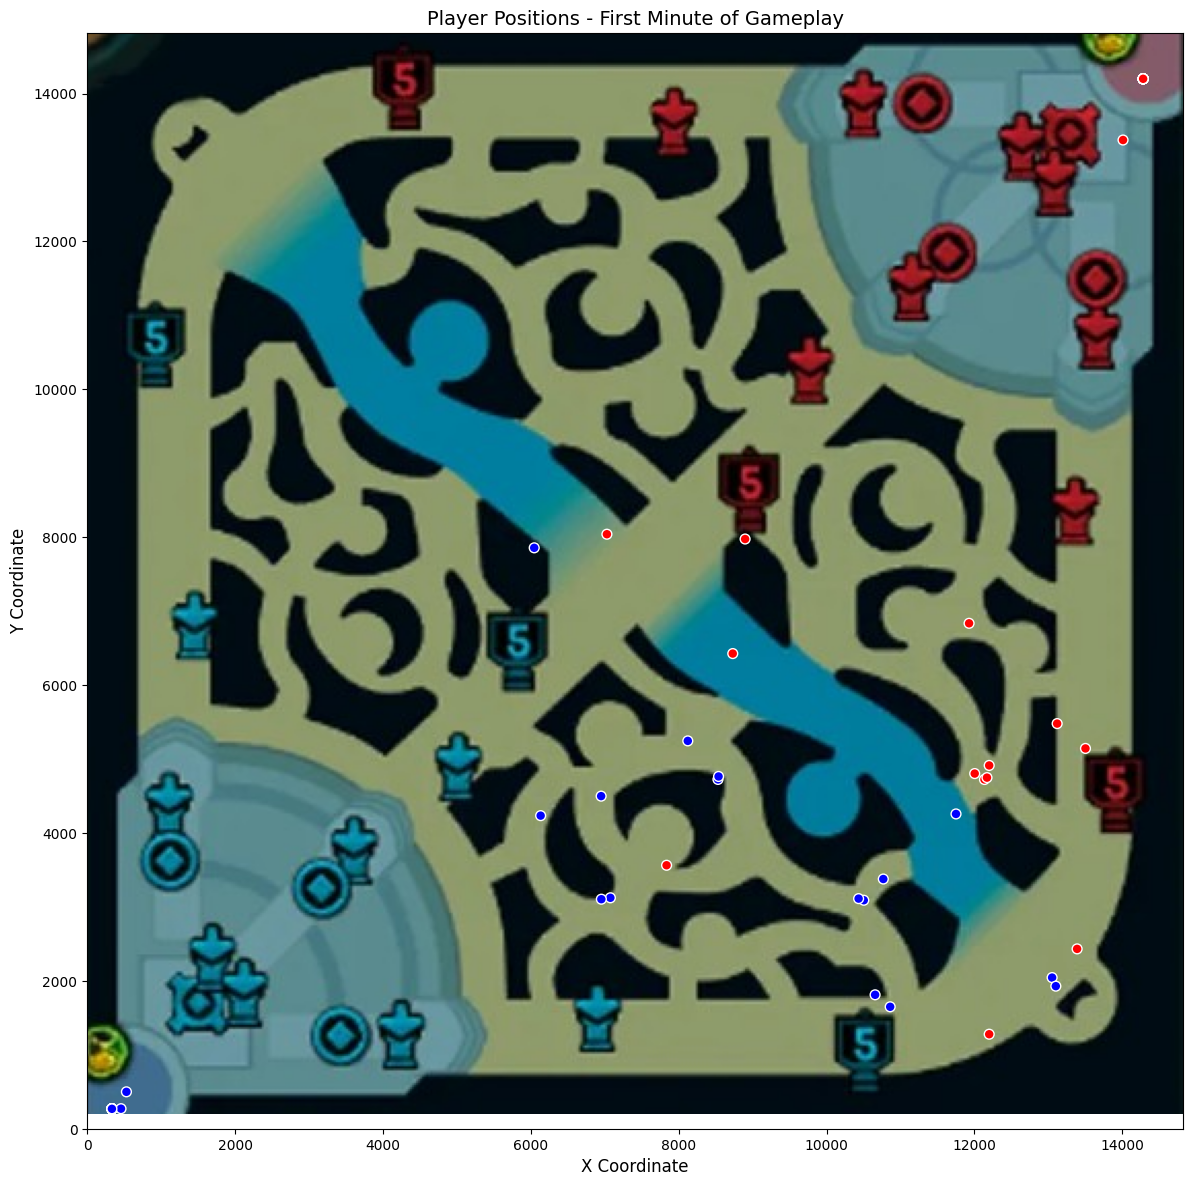

In [157]:
import matplotlib.pyplot as plt
from PIL import Image

# Load the League of Legends minimap image
image_path = 'League-of-Legends-Minimap.jpg'
img = Image.open(image_path)

# Create a figure with larger size for better visibility
fig, ax = plt.subplots(figsize=(12, 12))

# Display the image as background
# League of Legends map coordinates typically range from 0 to ~14820
# Set extent to match the game's coordinate system
# Adjust y_shift to move image up (positive) or down (negative)
y_shift = 200  # Adjust this value to move the image up/down
x_shift = 0
ax.imshow(img, extent=[x_shift, 14820 + x_shift, y_shift, 14820 + y_shift])

# Map team IDs to colors (100 = Blue side, 200 = Red side)
color_map = {'blue': 'blue', 'red': 'red'}
colors = [color_map[side] for side in current_player_match_timeline_df['side']]

# Plot the scatter points with better visibility
ax.scatter(one_minute_x_coord, one_minute_y_coord, c=colors, s=50, edgecolors='white', linewidths=1)

# Set labels and title
ax.set_xlabel('X Coordinate', fontsize=12)
ax.set_ylabel('Y Coordinate', fontsize=12)
ax.set_title('Player Positions - First Minute of Gameplay', fontsize=14)

# Set axis limits to match LoL map
ax.set_xlim(0, 14820)
ax.set_ylim(0, 14820)

plt.tight_layout()
plt.show()

## Ganks stats

In [ ]:
import requests

def get_match_timeline(match_id, api_key):
    url = f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}/timeline"
    r = requests.get(url, headers={"X-Riot-Token": api_key})
    return r.json()

def gank_deaths(match_data, timeline_data, puuid):
    player = next(p for p in match_data["info"]["participants"] if p["puuid"] == puuid)
    player_id = player["participantId"]
    lane = player["teamPosition"]
    events = []
    for frame in timeline_data["info"]["frames"]:
        for e in frame.get("events", []):
            if e["type"] == "CHAMPION_KILL" and e["victimId"] == player_id:
                if e["timestamp"] < 600000:  # ~10 min
                    if e.get("assistingParticipantIds"):
                        killers = [e.get("killerId")] + e.get("assistingParticipantIds", [])
                        killers = [k for k in killers if k]  # filter None
                        participants = match_data["info"]["participants"]
                        killer_roles = [p["teamPosition"] for p in participants if p["participantId"] in killers]
                        events.append(e)
    return events
# Example usage
api_key = os.getenv("riot_api_key")
match_id = "NA1_5401407485"
match_data = requests.get(
    f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}",
    headers={"X-Riot-Token": api_key}
).json()
timeline_data = get_match_timeline(match_id, api_key)
ganks = gank_deaths(match_data, timeline_data, puuid="jgIFggFSUWMaiXjdREgaDpoQOcs5uyzwaS8tm781QGJtJHJazhaY1xPG5z9uUtSEy8CKDzQodTmTGQ")
print(f"Gank deaths: {len(ganks)}")

KeyError: 'info'

In [5]:
# Example usage
api_key = os.getenv("riot_api_key")

ganks = []
for match_id in matches_df['match_id']:

    timeline_data = get_match_timeline(match_id, api_key)

    # gank = gank_deaths(match_data, timeline_data, puuid="jgIFggFSUWMaiXjdREgaDpoQOcs5uyzwaS8tm781QGJtJHJazhaY1xPG5z9uUtSEy8CKDzQodTmTGQ")
    gank = gank_deaths(match_data, timeline_data, puuid="ZzKy705E6fkzFEscD6HBqypYH3EWriEgumWJPgH-RU2l-NK-Zg40flY03DB-JxmuUWtlTGkzQYRqHw")
    if gank:
        ganks.append(gank)
        print(f"Gank deaths: {len(gank)}")

NameError: name 'matches_df' is not defined

In [56]:
x_coords = []
y_coords = []
for gank in ganks:
    for event in gank:
        x_coords.append(event['position']['x'])
        y_coords.append(event['position']['y'])

In [ ]:
# x_coord = ganks[0]['position']['x']
# y_coord = ganks[0]['position']['y']

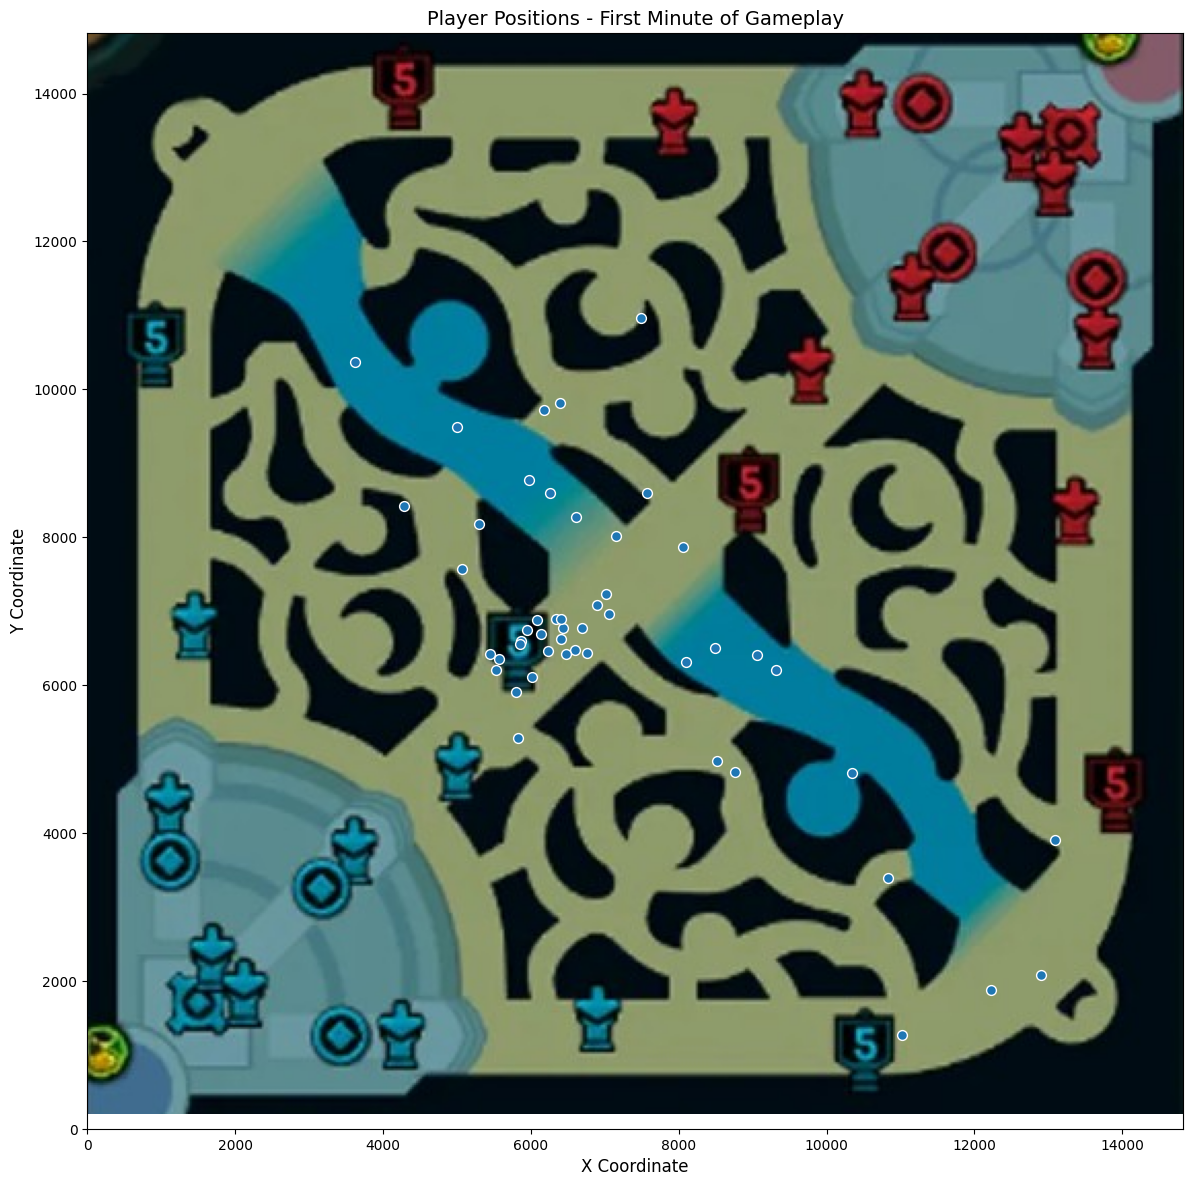

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Load the League of Legends minimap image
image_path = 'League-of-Legends-Minimap.jpg'
img = Image.open(image_path)

# Create a figure with larger size for better visibility
fig, ax = plt.subplots(figsize=(12, 12))

y_shift = 200  # Adjust this value to move the image up/down
x_shift = 0
ax.imshow(img, extent=[x_shift, 14820 + x_shift, y_shift, 14820 + y_shift])

ax.scatter(x_coords, y_coords, s=50, edgecolors='white', linewidths=1)

# Set labels and title
ax.set_xlabel('X Coordinate', fontsize=12)
ax.set_ylabel('Y Coordinate', fontsize=12)
ax.set_title('Player Positions - First Minute of Gameplay', fontsize=14)

# Set axis limits to match LoL map
ax.set_xlim(0, 14820)
ax.set_ylim(0, 14820)

plt.tight_layout()
plt.show()

## cs@14

In [3]:
connection_url = create_db_connection_string(db_username, db_password, db_host, db_port, db_name)
db_engine = create_engine(connection_url, pool_recycle=3600)
connection = db_engine.connect()

In [4]:

with db_engine.connect() as connection:
    matches_df = pd.read_sql(text("SELECT * FROM soloq.player_matches"), connection)

with db_engine.connect() as connection:
    match_timeline_df = pd.read_sql(text("SELECT * FROM soloq.player_matches_timeline"), connection)


In [5]:
current_player_username = 'RoboBoto'
team_position = 'BOTTOM'

current_player_puuid = matches_df[matches_df['username'] == current_player_username]['puuid'].iloc[0]

matches_df = matches_df[(matches_df['username'] == current_player_username) & (matches_df['team_position'] == team_position)]
current_player_match_timeline_df = match_timeline_df[match_timeline_df['puuid'] == current_player_puuid].copy()

In [6]:
match_ids = matches_df['match_id'].tolist()

cs_at_10 = []
for match_id in match_ids[:1]:
    filtered_match_timeline_df = current_player_match_timeline_df[current_player_match_timeline_df['match_id'] == match_id]
    filtered_match_timeline_df = filtered_match_timeline_df[(filtered_match_timeline_df['timestamp'] <= 15) & (filtered_match_timeline_df['timestamp'] >= 14)]
    filtered_match_timeline_df['cs_at_14'] = filtered_match_timeline_df['minions_killed'] + filtered_match_timeline_df['jungle_minions_killed']
    # print(filtered_match_timeline_df['cs_at_10'])
    cs_at_10.append(filtered_match_timeline_df['cs_at_14'].iloc[0])

print(f'cs_per_minute: {np.mean(cs_at_10)/14}')
# cs_at_10


cs_per_minute: 6.357142857142857


## CS@14 vs opponent laner

In [36]:
connection_url = create_db_connection_string(db_username, db_password, db_host, db_port, db_name)
db_engine = create_engine(connection_url, pool_recycle=3600)
connection = db_engine.connect()

In [37]:

with db_engine.connect() as connection:
    matches_df = pd.read_sql(text("SELECT * FROM soloq.player_matches"), connection)

with db_engine.connect() as connection:
    match_timeline_df = pd.read_sql(text("SELECT * FROM soloq.player_matches_timeline"), connection)


In [38]:
current_player_username = 'bruhdun'
team_position = 'JUNGLE'

current_player_username = 'hawnlilmonster'
team_position = 'TOP'

current_player_username = 'oanduh'
team_position = 'MIDDLE'

current_player_username = 'RoboBoto'
team_position = 'BOTTOM'

current_player_puuid = matches_df[matches_df['username'] == current_player_username]['puuid'].iloc[0]

matches_df = matches_df[(matches_df['username'] == current_player_username) & (matches_df['team_position'] == team_position)]


In [39]:
filtered_match_timeline_df = match_timeline_df[match_timeline_df['match_id'].isin(matches_df['match_id'])]
filtered_match_timeline_df = filtered_match_timeline_df[(filtered_match_timeline_df['timestamp'] <= 15) & (filtered_match_timeline_df['timestamp'] >= 14)]
current_player_df = filtered_match_timeline_df[filtered_match_timeline_df['puuid'] == current_player_puuid].set_index('match_id')
lane_participant_ids = current_player_df['participant_id'].unique()
opponents_df = filtered_match_timeline_df[((filtered_match_timeline_df['participant_id'] == lane_participant_ids[0]) | (filtered_match_timeline_df['participant_id'] == lane_participant_ids[1])) & (filtered_match_timeline_df['puuid'] != current_player_puuid)].set_index('match_id')

In [40]:
current_player_df['current_player_cs_at_10'] = current_player_df['minions_killed'] + current_player_df['jungle_minions_killed']
opponents_df['opponent_cs_at_10'] = opponents_df['minions_killed'] + opponents_df['jungle_minions_killed']
combined_df = current_player_df[['current_player_cs_at_10']].join(opponents_df[['opponent_cs_at_10']], how='left')

In [41]:
cs = []
for index, row in combined_df.iterrows():
    cs.append(row['current_player_cs_at_10'] - row['opponent_cs_at_10'])

print('first 14 minutes current player cs: ', np.mean(current_player_df['current_player_cs_at_10']))
print('cs/min: ', np.mean(current_player_df['current_player_cs_at_10'])/14)
print('first 14 minutes opponent cs: ', np.mean(opponents_df['opponent_cs_at_10']))
print('cs/min: ', np.mean(opponents_df['opponent_cs_at_10'])/14)
print('first 14 minutes cs difference: ', np.mean(cs))


first 14 minutes current player cs:  99.2
cs/min:  7.085714285714286
first 14 minutes opponent cs:  107.06666666666666
cs/min:  7.647619047619047
first 14 minutes cs difference:  -7.866666666666666


In [42]:
print('first 14 minutes current player xp: ', np.mean(current_player_df['xp']))
print('xp/min: ', np.mean(current_player_df['xp'])/14)
print('first 14 minutes opponent xp: ', np.mean(opponents_df['xp']))
print('xp/min: ', np.mean(opponents_df['xp'])/14)
print('first 14 minutes xp difference: ', np.mean(current_player_df['xp'] - opponents_df['xp']))

first 14 minutes current player xp:  5071.333333333333
xp/min:  362.23809523809524
first 14 minutes opponent xp:  5054.6
xp/min:  361.04285714285714
first 14 minutes xp difference:  16.733333333333334


In [43]:
print('first 14 minutes current player gold: ', np.mean(current_player_df['total_gold']))
print('gold/min: ', np.mean(current_player_df['total_gold'])/14)
print('first 14 minutes opponent gold: ', np.mean(opponents_df['total_gold']))
print('gold/min: ', np.mean(opponents_df['total_gold'])/14)
print('first 14 minutes gold difference: ', np.mean(current_player_df['total_gold'] - opponents_df['total_gold']))


first 14 minutes current player gold:  4947.0
gold/min:  353.35714285714283
first 14 minutes opponent gold:  5161.133333333333
gold/min:  368.65238095238095
first 14 minutes gold difference:  -214.13333333333333


## typical ward placements

In [3]:
import requests

def get_match_timeline(match_id, api_key):
    url = f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}/timeline"
    r = requests.get(url, headers={"X-Riot-Token": api_key})
    return r.json()

def gank_deaths(match_data, timeline_data, puuid):
    player = next(p for p in match_data["info"]["participants"] if p["puuid"] == puuid)
    player_id = player["participantId"]
    lane = player["teamPosition"]
    events = []
    for frame in timeline_data["info"]["frames"]:
        for e in frame.get("events", []):
            if e["type"] == "CHAMPION_KILL" and e["victimId"] == player_id:
                if e["timestamp"] < 600000:  # ~10 min
                    if e.get("assistingParticipantIds"):
                        killers = [e.get("killerId")] + e.get("assistingParticipantIds", [])
                        killers = [k for k in killers if k]  # filter None
                        participants = match_data["info"]["participants"]
                        killer_roles = [p["teamPosition"] for p in participants if p["participantId"] in killers]
                        events.append(e)
    return events
# Example usage
api_key = os.getenv("riot_api_key")
match_id = "NA1_5401407485"
match_data = requests.get(
    f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}",
    headers={"X-Riot-Token": api_key}
).json()
timeline_data = get_match_timeline(match_id, api_key)
# ganks = gank_deaths(match_data, timeline_data, puuid="jgIFggFSUWMaiXjdREgaDpoQOcs5uyzwaS8tm781QGJtJHJazhaY1xPG5z9uUtSEy8CKDzQodTmTGQ")
# print(f"Gank deaths: {len(ganks)}")

In [12]:
timeline_data['info']['frames'][16]['events']

[{'level': 12, 'participantId': 3, 'timestamp': 900484, 'type': 'LEVEL_UP'},
 {'creatorId': 5,
  'timestamp': 900985,
  'type': 'WARD_PLACED',
  'wardType': 'SIGHT_WARD'},
 {'creatorId': 7,
  'timestamp': 902087,
  'type': 'WARD_PLACED',
  'wardType': 'UNDEFINED'},
 {'creatorId': 8,
  'timestamp': 903156,
  'type': 'WARD_PLACED',
  'wardType': 'YELLOW_TRINKET'},
 {'creatorId': 7,
  'timestamp': 903957,
  'type': 'WARD_PLACED',
  'wardType': 'UNDEFINED'},
 {'creatorId': 7,
  'timestamp': 905828,
  'type': 'WARD_PLACED',
  'wardType': 'UNDEFINED'},
 {'levelUpType': 'NORMAL',
  'participantId': 3,
  'skillSlot': 3,
  'timestamp': 906663,
  'type': 'SKILL_LEVEL_UP'},
 {'creatorId': 7,
  'timestamp': 907698,
  'type': 'WARD_PLACED',
  'wardType': 'UNDEFINED'},
 {'creatorId': 2,
  'timestamp': 909535,
  'type': 'WARD_PLACED',
  'wardType': 'YELLOW_TRINKET'},
 {'creatorId': 7,
  'timestamp': 909568,
  'type': 'WARD_PLACED',
  'wardType': 'UNDEFINED'},
 {'level': 11, 'participantId': 1, 'times

## avg kills by 14 vs opponent
Need to save events within another DB


In [51]:
connection_url = create_db_connection_string(db_username, db_password, db_host, db_port, db_name)
db_engine = create_engine(connection_url, pool_recycle=3600)
connection = db_engine.connect()

In [52]:

with db_engine.connect() as connection:
    matches_df = pd.read_sql(text("SELECT * FROM soloq.player_matches"), connection)

with db_engine.connect() as connection:
    match_timeline_df = pd.read_sql(text("SELECT * FROM soloq.player_matches_timeline"), connection)


In [53]:
current_player_username = 'bruhdun'
team_position = 'JUNGLE'

current_player_username = 'hawnlilmonster'
team_position = 'TOP'

# current_player_username = 'oanduh'
# team_position = 'MIDDLE'

# current_player_username = 'RoboBoto'
# team_position = 'BOTTOM'

current_player_puuid = matches_df[matches_df['username'] == current_player_username]['puuid'].iloc[0]

matches_df = matches_df[(matches_df['username'] == current_player_username) & (matches_df['team_position'] == team_position)]


In [ ]:
filtered_match_timeline_df = match_timeline_df[match_timeline_df['match_id'].isin(matches_df['match_id'])]
filtered_match_timeline_df = filtered_match_timeline_df[(filtered_match_timeline_df['timestamp'] <= 15) & (filtered_match_timeline_df['timestamp'] >= 14)]
current_player_df = filtered_match_timeline_df[filtered_match_timeline_df['puuid'] == current_player_puuid].set_index('match_id')
lane_participant_ids = current_player_df['participant_id'].unique()
opponents_df = filtered_match_timeline_df[((filtered_match_timeline_df['participant_id'] == lane_participant_ids[0]) | (filtered_match_timeline_df['participant_id'] == lane_participant_ids[1])) & (filtered_match_timeline_df['puuid'] != current_player_puuid)].set_index('match_id')

In [49]:
# 107.06666666666666*19.5 + 500
# 99.2 * 19.5 + 500

In [194]:
# [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# matches_timeline_filtered = filter df where we only capture 10 minute timestamp

# using matches_timeline_filtered create a filtered df where participant ids can only be 8 or 3 and are not the puuid of the current player

# using matches_timeline_filtered create a filtered df where the puuid is only the current player

# combine the two filtered dfsbased on the matchid set as an index



## winrate based on cs difference?

## avg successful ganks vs opponent